# B Map and Methods Comparison

## Requisites

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit    
import numpy as np
import pyslim
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData, GenomicBins
from bgspy.utils import mean_ratio, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, exact_index, bin_chroms
from bgspy.plots import sizes, get_figax, chromosome_ticks_formatter, smooth

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [3]:
plt.show() # hack to solve some mpl issue 
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

In [4]:
FIGDIR = '../manuscript/figures/'

In [5]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

## Load Data

### bgspy B, B', and locally-rescaled B' maps

In [6]:
# B and B'
pkl_b_file = '../slim_sims/chrombgs/runs/conserved_cds_utrs_phastcons_merged__hapmap__fixed_empiricalB/bmaps/N__1000/chrom__chr10/bmap__conserved_cds_utrs_phastcons_merged__hapmap__fixed_empiricalB.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

bp = m.BpScores
b = m.BScores

In [7]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [8]:
# locally-recaled B'
pkl_rs_b_file = '../data/bmaps/bgspy/rescaled_grid/bmap_rescaled_hg38_sims_1e-8w_1e-3t_10000step_chr10.pkl'
m_rs = BGSModel.load(pkl_rs_b_file)

bp_rs = m_rs.BpScores

### Simulation Data

`sim_B` is a `.npz` object with mean, variance, and the raw data for all replicates (`X`).

In [9]:
sim_B = np.load('../slim_sims/chrombgs/empiricalB_chr10__expansion_false__h_0.5__results.npz', allow_pickle=True)
mus = sim_B['mu']
shs = sim_B['sh']

In [10]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [11]:
# shape of raw data -- last dimension is number of replicates
sim_B['X'].shape

(133798, 6, 11, 100)

In [12]:
NSIMS = sim_B['X'].shape[3]
NSIMS

100

To get a sense of the variance across simulation replicates, let's average all replicates and look at how the mean varies across chromosomal space.

In [13]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [14]:
sim_B['X'].shape

(133798, 6, 11, 100)

Now, for convenience we load the means and standard deviations into `BScores` objects.  

In [15]:
#m.segments.load_rescaling_from_fixed_params(m.BpScores, 1e-8, 1e-2)

In [16]:
# create midpoints
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': sims_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [17]:
sims = BScores({'chr10': np.log(sim_B['X'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [18]:
sim_means_100kb = sims_means.bin_means(GenomicBins(g.seqlens, 100_000))
sim_means_500kb = sims_means.bin_means(GenomicBins(g.seqlens, 500_000))
sim_means_1Mb = sims_means.bin_means(GenomicBins(g.seqlens, 1_000_000))

sim_sd_500kb = sims_sds.bin_means(GenomicBins(g.seqlens, 500_000))
sim_sd_100kb = sims_sds.bin_means(GenomicBins(g.seqlens, 100_000))
sim_sd_1Mb = sims_sds.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [19]:
sims_1Mb = sims.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [20]:
list(sim_B.keys())

['mu', 'sh', 'pos', 'X', 'nreps', 'mean', 'sd', 'files']

### Load McVicker's `calc_bkgd`  data

In [21]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_10000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)
mcvb.w, mcvb.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

## B Map Comparisons Across Simulations and Theory


### Mean Squared Error, Relative Error, and Bias

We compute the MSE, bias, etc between simulations for binned values at the megabase scale. Only for chromosome 10.

In [22]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [23]:
# this is used for simulation YAML file
print('\n'.join([f' - {f}' for f in m.t.tolist()]))

 - 1e-06
 - 3.16e-06
 - 1e-05
 - 3.16e-05
 - 0.0001
 - 0.000316
 - 0.001
 - 0.00316
 - 0.01
 - 0.0316
 - 0.1


In [24]:
def mse(x, y):
    return np.mean((x-y)**2)

def relerror(obs, real):
    return np.mean(np.abs(obs - real)/real)


mb_bins =  bin_chroms(g.seqlens, 1e6)

rows = list()
for w, t in itertools.product(m.w, m.t):
    sx, sy = sim_means_1Mb['chr10', w, t]
    bx, by = b.bin_means(mb_bins)['chr10', w, t]
    bpx, bpy = bp.bin_means(mb_bins)['chr10', w, t]
    bp_rs_x, bp_rs_y = bp_rs.bin_means(mb_bins)['chr10', w, t]

    rows.append(dict(w=w, t=t, b_mse=mse(by, sy), bp_mse=mse(bpy, sy), bp_rs_mse=mse(bp_rs_y, sy), 
                     b_relerror=relerror(by, sy), bp_relerror=relerror(bpy, sy), 
                       bp_rs_relerror=mse(bp_rs_y, sy), 
                     b_bias=np.mean(by - sy), bp_bias=np.mean(bpy - sy),
                       bp_rs_bias=np.mean(bp_rs_y - sy), 
                    
                    ))
    
mse_df = pd.DataFrame(rows)

Save this as supplementary data.

In [25]:
mse_df.to_csv("../data/supplementary_data/theory_simulation_comparison.tsv", sep='\t', index=False)

What is the theoretic minimum, e.g. if simulations were exact?

We have a true $B(x)$ function, and we simulate. Assume the noise around $B(x)$ is entirely due to the neutral coalescent with rescaled-$N_e$. Then, we have

$$\mathrm{E}((B(x) - \bar{B}_\mathrm{sim}(x))^2) = \mathrm{V}(\bar{B}_\mathrm{sim}(x)) + \text{Bias}(\bar{B}_\mathrm{sim}(x), B(x))^2$$

the, note that averaging over the number of simulations $n$,

$$
\mathrm{V}(\bar{B}(x)) = \frac{\mathrm{V}(\hat{B}(x))}{n}
$$

The theoretic variance for $\mathrm{V}(\hat{B}_\mathrm{sim}(x))$ is derived below.


If we care about simulating some process and learning about some parameter from the observed $T_2$s (or some function of them), we need to get sense of the noise around $\pi$ and $T_2$. According to Tajima (1983), the variance in $\pi$ is:

$$\text{Var}(\pi) = \frac{n + 1}{3(n-1)} \theta + \frac{2(n^2 + n + 3)}{9n(n-1)}\theta^2$$

In the limit as $n \to \infty$, $\text{Var} = \frac{1}{9}(3 \theta + 2 \theta^2)$. The first term is the sampling variation, the second is the evolutionary variation. 

Note that if we use $\hat{B} = \pi / 4N$, $\text{Var}(\hat{B}) = \text{Var}(\pi)/4N^2$, which simplifies to:

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)}\frac{\mu}{4N}+\frac{2 \left(n^2+n+3\right)}{9 (n-1) n}\mu^2 $$

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)} \frac{\theta}{16N^2}  + \frac{2 \left(n^2+n+3\right)}{9 (n-1) n} \frac{\theta^2}{16N^2} $$


In [26]:
sim_means_1Mb.B['chr10'].shape

(134, 6, 11)

In [27]:
def B_var_limit(N, mu=1):
    return (3*mu + 8*N*mu**2)/(36*N)

In [28]:
@np.vectorize
def B_var_limit(B, R=1, N=None, n=None):
    if N is None or n is None:
        # the case where n = N, and N --> inf
        return 2/9 * B**2 / R
    #VarBhat = (n+1)*B / (12*N*(n-1)) + 2*(n**2 + n + 3)*B**2 / (9*n*(n-1))
    VarBhat = (n+1)/(12*(n-1)) + B/(N*R) + (2*(n**2 + n + 3))/ (9*n*(n-1)) * B**2/R
    return VarBhat/R

B_var_limit(1, 200, 1000, 1000)

array(0.00042309)

In our case, fi there is no bias, the theoretic minimum 

Make some figures...

/tmp/ipykernel_57552/2307898939.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'selection coefficient')

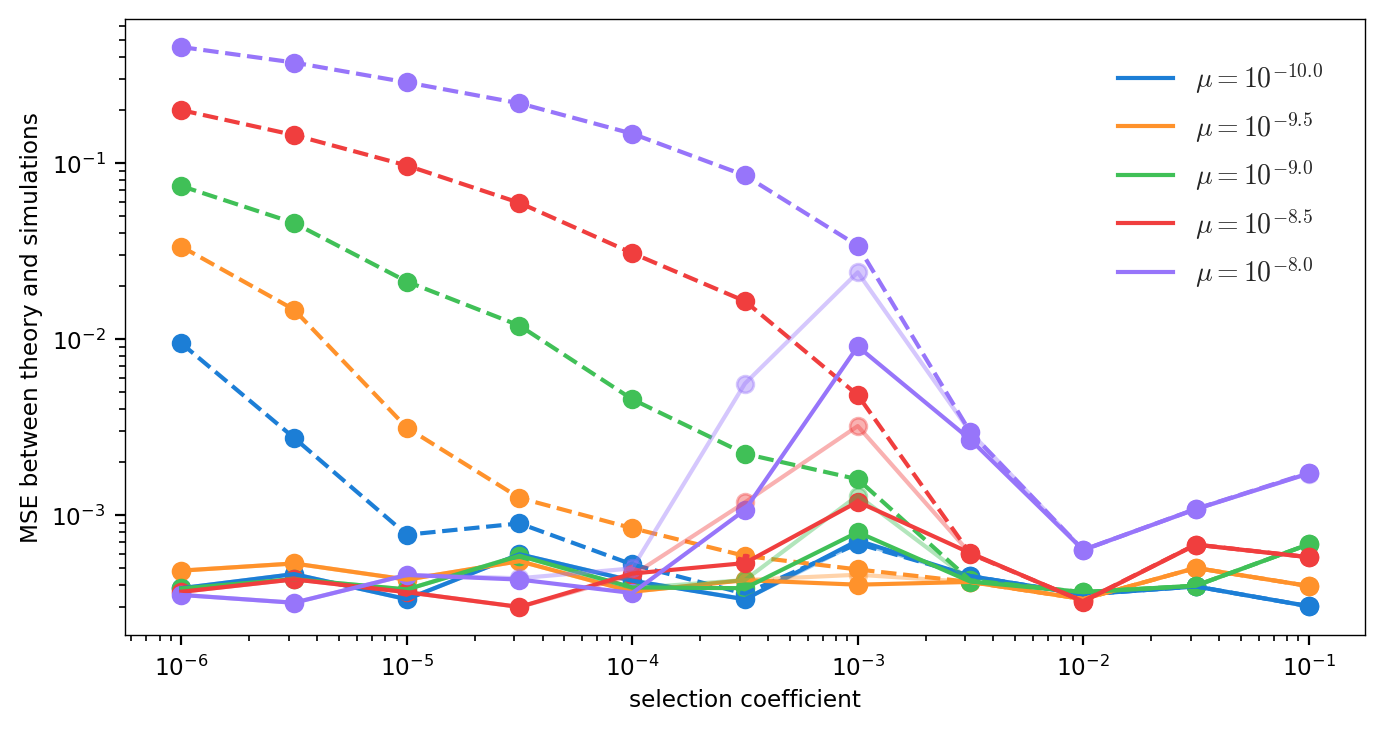

In [29]:
# with everything, B, B', and rescaled B'
fig, ax = plt.subplots()

for w in m.w:
    if w > 1e-8:
        continue
    mse_dfx = mse_df.loc[mse_df['w'] == w, :]
    
    # B'
    lines = plt.plot(mse_dfx.t, mse_dfx.bp_mse, label=f"$\\mu=10^{{{np.round(np.log10(w), 2)}}}$", alpha=0.4)
    ax.scatter(mse_dfx.t, mse_dfx.bp_mse, c=lines[0].get_color(), alpha=0.4)
    
    # rescaled
    plt.plot(mse_dfx.t, mse_dfx.bp_rs_mse, c=lines[0].get_color())
    ax.scatter(mse_dfx.t, mse_dfx.bp_rs_mse, c=lines[0].get_color())
    
    # classic
    ax.plot(mse_dfx.t, mse_dfx.b_mse, linestyle='dashed', c=lines[0].get_color())
    ax.scatter(mse_dfx.t, mse_dfx.b_mse, c=lines[0].get_color())

ax.loglog()
leg = ax.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
ax.set_ylabel("MSE between theory and simulations")
ax.set_xlabel("selection coefficient")

(4e-07, 0.2)

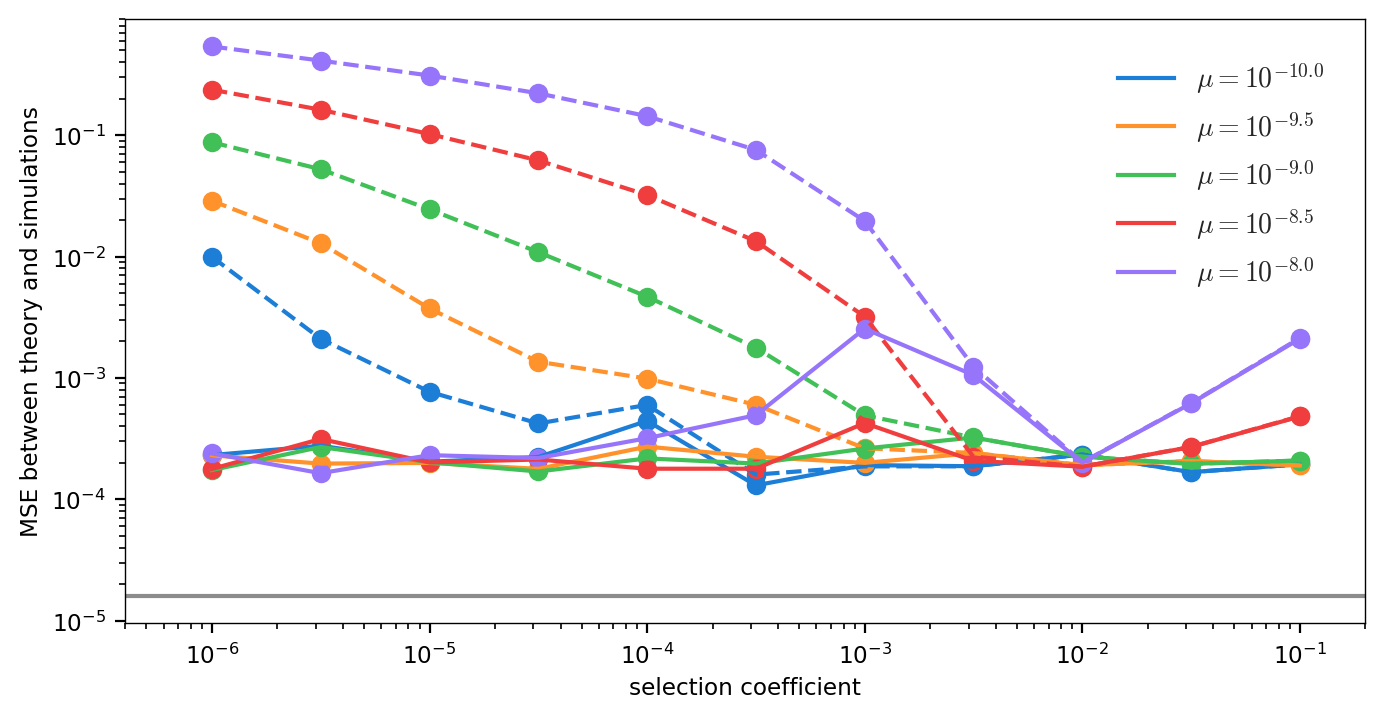

In [248]:
# just rescaled.
fig, ax = plt.subplots()

for w in m.w:
    if w > 1e-8:
        continue        
    mse_dfx = mse_df.loc[mse_df['w'] == w, :]
    
    # rescaled B'
    lines = plt.plot(mse_dfx.t, mse_dfx.bp_rs_mse, label=f"$\\mu=10^{{{np.round(np.log10(w), 2)}}}$")
    ax.scatter(mse_dfx.t, mse_dfx.bp_rs_mse, c=lines[0].get_color())
    
    # B
    ax.plot(mse_dfx.t, mse_dfx.b_mse, linestyle='dashed', c=lines[0].get_color())
    ax.scatter(mse_dfx.t, mse_dfx.b_mse, c=lines[0].get_color())
ax.loglog()
ax.legend()
lower_limit = np.mean(dvs, axis=0).var()


ax.axhline(lower_limit,
    #B_var_limit(B=1)/NSIMS**2, # note: this is the wrong theoretic limit
           #linestyle='dashed',
           c='0.55', zorder=-1)
ax.set_ylabel("MSE between theory and simulations")
ax.set_xlabel("selection coefficient")
ax.set_xlim(4e-7, 2e-1)
#ax.set_ylim(5e-5, ax.get_ylim()[1])
# ax.annotate("theoretic lower limit", (5e-7, lower_limit), (1e-5, 1e-4),
#             horizontalalignment='left', verticalalignment='top',
#             arrowprops=dict(color='0.22', arrowstyle='-|>',
#                             connectionstyle="angle,rad=10,angleB=-90,angleA=0"),
#             xycoords='data')

/tmp/ipykernel_31053/1968532118.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'selection coefficient')

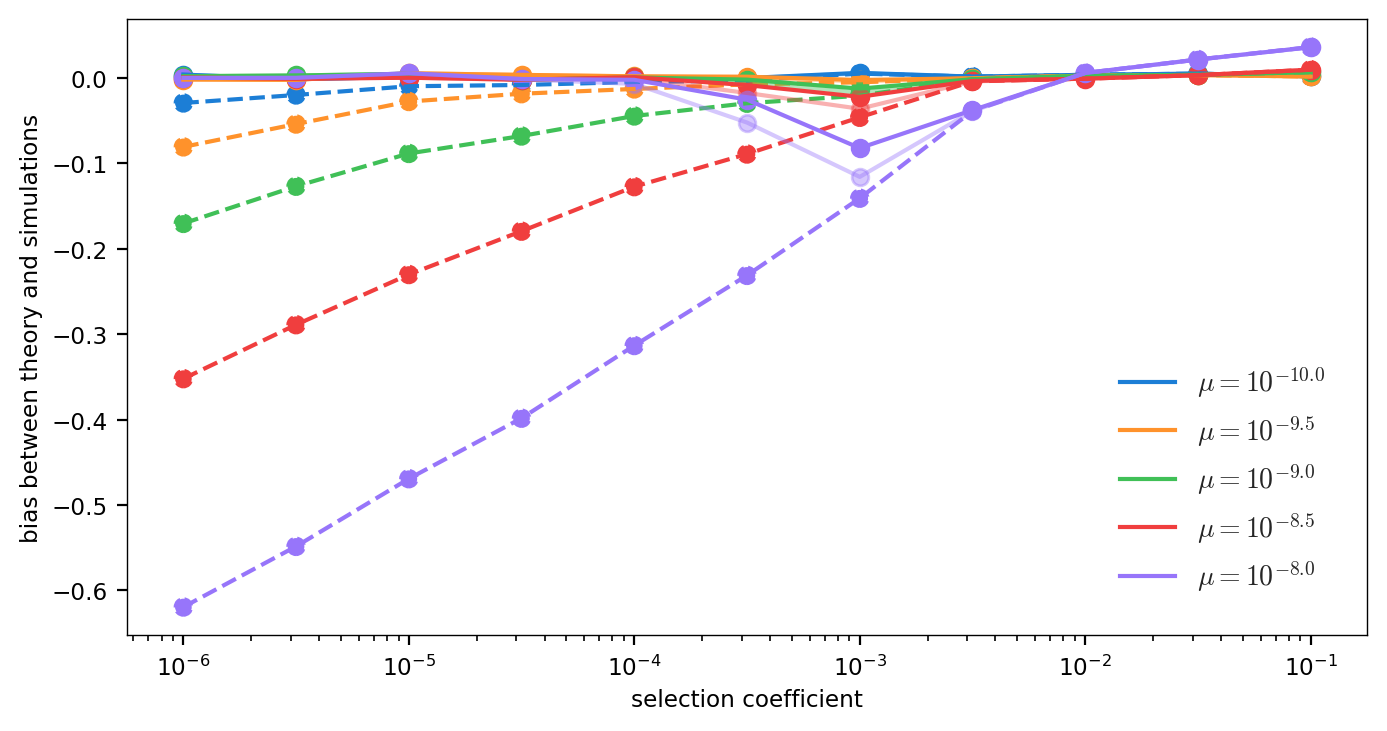

In [98]:
# bias
fig, ax = plt.subplots()

#np.seterr(under='ignore')

for w in m.w:
    if w > 1e-8:
        continue    
    mse_dfx = mse_df.loc[mse_df['w'] == w, :]

    # B' bias
    lines = plt.plot(mse_dfx.t, mse_dfx.bp_bias, label=f"$\\mu=10^{{{np.round(np.log10(w), 2)}}}$", alpha=0.4)
    ax.scatter(mse_dfx.t,mse_dfx.bp_bias, c=lines[0].get_color(), alpha=0.4)
    
    # rescaled
    plt.plot(mse_dfx.t, mse_dfx.bp_rs_bias, c=lines[0].get_color())
    ax.scatter(mse_dfx.t, mse_dfx.bp_rs_bias, c=lines[0].get_color())
    
    # B
    ax.plot(mse_dfx.t, mse_dfx.b_bias, linestyle='dashed', c=lines[0].get_color())
    ax.scatter(mse_dfx.t, mse_dfx.b_bias, linestyle='dashed', c=lines[0].get_color())
ax.semilogx()
leg = ax.legend()

for lh in leg.legendHandles:
    lh.set_alpha(1)

ax.set_ylabel("bias between theory and simulations")
ax.set_xlabel("selection coefficient")
#ax.set_yscale('symlog')

/tmp/ipykernel_31053/3352752856.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)
/tmp/ipykernel_31053/3352752856.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('10%', '100%'))


Text(0.5, 0, 'selection coefficient')

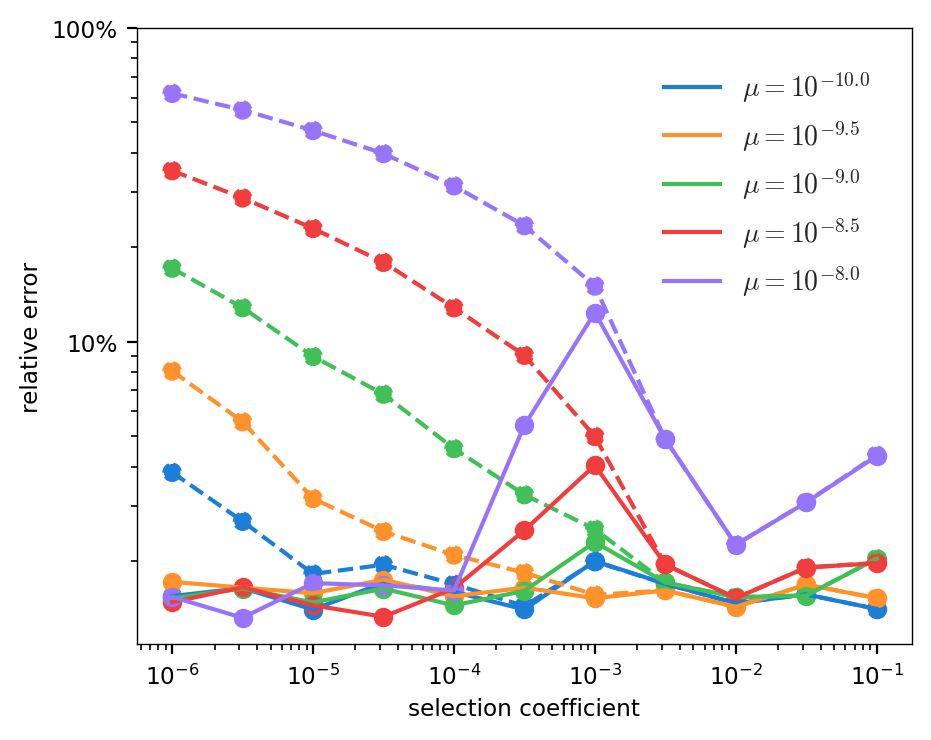

In [99]:
## draft for a main panel figure

fig, ax = plt.subplots(figsize=(5, 4))

for w in m.w:
    if w > 1e-8:
        continue    
    mse_dfx = mse_df.loc[mse_df['w'] == w, :]
    lines = plt.plot(mse_dfx.t, 100*mse_dfx.bp_relerror, label=f"$\\mu=10^{{{np.round(np.log10(w), 2)}}}$")
    ax.scatter(mse_dfx.t, 100*mse_dfx.bp_relerror, c=lines[0].get_color())
    
    ax.plot(mse_dfx.t, 100*mse_dfx.b_relerror, linestyle='dashed', c=lines[0].get_color())
    ax.scatter(mse_dfx.t, 100*mse_dfx.b_relerror, linestyle='dashed', c=lines[0].get_color())
ax.loglog()
#ax.semilogx()
ax.legend()
ax.set_ylim(0, 100)
#ax.set_xlim(1e-7, 1.1e-1)
#ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
#ax.ticklabel_format(style='plain', axis='y',useOffset=False)
ax.set_yticklabels(('10%', '100%'))
ax.set_yticks((10, 100))
ax.set_ylabel("relative error")
ax.set_xlabel("selection coefficient")

### Comparison Along Chromsome

Note that the simulations are heteroscedastic across $B(x)$, and the level varies across parameters (below).

This could be due to varying levels of polymorphism along the genome — except that where diversity is the lowest (low recombination regions), we'd expect fewer segregating sites, and thus *higher* variance; here we see the opposite.

Thus, the BGS process (under strong-ish selection) is reducing the variance in coalescent times.

/tmp/ipykernel_31053/2405019921.py:67: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


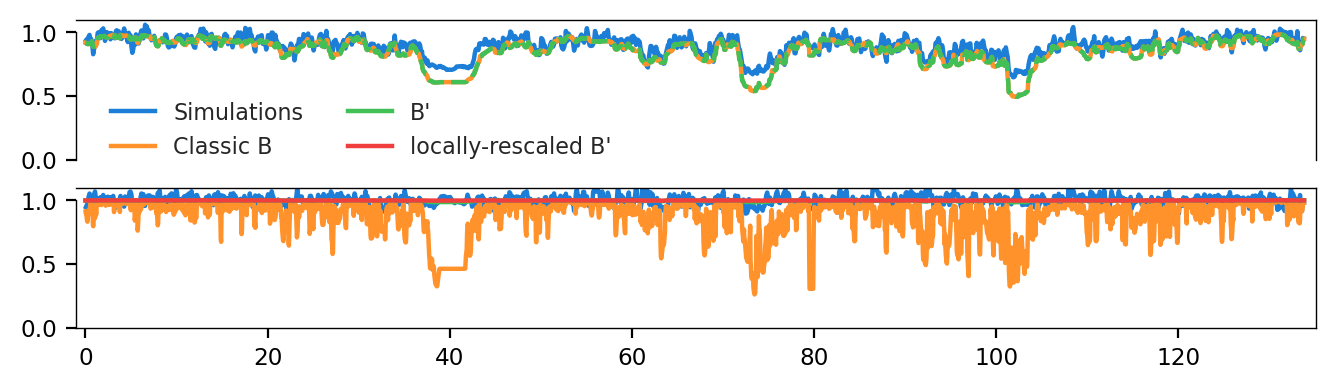

In [100]:
show_sd = False
lwd = 1.6
ticks_x = mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e6))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(8, 2))
w, t = 1e-8, 3.16e-3
bb = m.BpScores['chr10', w, t]

ax[0].plot(*sim_means_100kb['chr10', w, t], label="Simulations", linewidth=lwd)
ax[0].plot(*b['chr10', w, t], label="Classic B", linewidth=lwd)
ax[0].plot(*bp['chr10', w, t], label="B'", linestyle='dashed', linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[0].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

#ax[0].set_ylim(0.5, 1.1)
ax[0].set_ylim(0, 1.1)

ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
#ax[0].grid()
ax[0].spines.left.set_bounds((0, 1))
ax[0].xaxis.set_major_formatter(ticks_x)
ax[0].set_xlim(-1000000, 1.01*g.seqlens['chr10'])

############ Weak selection sample

w, t = 3.16e-9, 1e-4
#w, t = 1e-8, 1e-3
mb_bins = bin_chroms(g.seqlens, 40e3)

ax[1].plot(*sim_means_100kb['chr10', w, t], 
           #label="Simulations",
           linewidth=lwd)
ax[1].plot(*b.bin_means(mb_bins)['chr10', w, t], 
           #label="Classic BGS Theory", 
           linewidth=lwd)

ax[1].plot(*bp['chr10', w, t], #label="New Theory",
           linewidth=lwd)

# rescaled B'
lines = ax[1].plot(*bp_rs['chr10', w, t], label="locally-rescaled B'", linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)


lines1, labels1 = ax[0].get_legend_handles_labels()
lines2, labels2 = ax[1].get_legend_handles_labels()
leg = ax[0].legend(lines1 + lines2,
                   labels1 + labels2,
                   ncol=2, loc=(0.01, -0.15),
                  fontsize=8)

    
mb_bins = bin_chroms(g.seqlens, 10e4)
b.bin_means(mb_bins)
#ax[1].grid(axis='y')
ax[1].set_ylim(0, 1.1)
ax[1].spines.left.set_bounds((0, 1))

for handle in leg.legendHandles:
    #handle.set_linewidth(2.0)
    handle.set_linestyle('solid')

/tmp/ipykernel_31053/1855712799.py:110: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


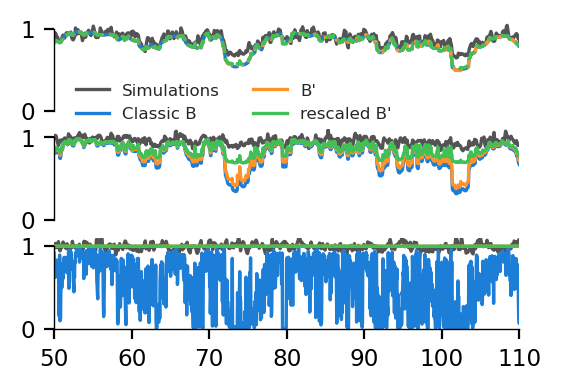

In [101]:
simcol = '0.33'
show_sd = False
lwd = 1.2
ticks_x = chromosome_ticks_formatter(1e6)

fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(3, 2))
w, t = 1e-8, 3.16e-3
bb = m.BpScores['chr10', w, t]

ax[0].plot(*sim_means_100kb['chr10', w, t], label="Simulations", c=simcol, linewidth=lwd)
ax[0].plot(*b['chr10', w, t], label="Classic B", linewidth=lwd)
ax[0].plot(*bp['chr10', w, t], label="B'", linestyle='dashed', linewidth=lwd)
ax[0].plot(*bp_rs['chr10', w, t], label="rescaled B'", linestyle='dashed', linewidth=lwd)


if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[0].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)

#ax[0].set_ylim(0.5, 1.1)
ax[0].set_ylim(0, 1.1)

ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
#ax[0].grid()
ax[0].spines.left.set_bounds((0, 1))
ax[0].xaxis.set_major_formatter(ticks_x)
ax[0].set_xlim(-1000000, 1.01*g.seqlens['chr10'])

############ Ns = selection sample

w, t = 1e-8, 1e-3
mb_bins = bin_chroms(g.seqlens, 40e3)

ax[1].plot(*sim_means_100kb['chr10', w, t], 
           #label="Simulations",
           c=simcol,
           linewidth=lwd)
ax[1].plot(*b.bin_means(mb_bins)['chr10', w, t], 
           #label="Classic BGS Theory", 
           linewidth=lwd)

ax[1].plot(*bp['chr10', w, t], #label="New Theory",
           linewidth=lwd)

# rescaled B'
lines = ax[1].plot(*bp_rs['chr10', w, t], linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)


############ Weak selection sample

w, t = 1e-8, 1e-5
#w, t = 1e-8, 1e-3
mb_bins = bin_chroms(g.seqlens, 40e3)

ax[2].plot(*sim_means_100kb['chr10', w, t], 
           #label="Simulations",
           c=simcol,
           linewidth=lwd)
ax[2].plot(*b.bin_means(mb_bins)['chr10', w, t], 
           #label="Classic BGS Theory", 
           linewidth=lwd)

ax[2].plot(*bp['chr10', w, t],# label="New Theory",
           linewidth=lwd)

# rescaled B'
lines = ax[2].plot(*bp_rs['chr10', w, t],  label="rescaled B'", linewidth=lwd)

if show_sd:
    simsd = sim_sd_100kb['chr10', w, t]
    simm = sim_means_100kb['chr10', w, t]
    ax[1].fill_between(simm[0], simm[1] - 0.5*simsd[1], simm[1] + 0.5*simsd[1], alpha=0.3)


lines1, labels1 = ax[0].get_legend_handles_labels()
#lines2, labels2 = ax[2].get_legend_handles_labels()
leg = ax[0].legend(lines1,# + lines2,
                   labels1,# + labels2,
                   ncol=2, loc=(0.01, -0.3),
                  fontsize=6)

    
mb_bins = bin_chroms(g.seqlens, 10e4)
b.bin_means(mb_bins)
#ax[1].grid(axis='y')
ax[1].set_ylim(0, 1.1)
ax[1].spines.left.set_bounds((0, 1))

ax[2].set_ylim(0, 1.1)
ax[2].spines.left.set_bounds((0, 1))

ax[0].spines.right.set_visible(False)
ax[0].spines.top.set_visible(False)

ax[1].spines.right.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].spines.bottom.set_visible(False)
ax[1].xaxis.set_visible(False)

ax[2].spines.top.set_visible(False)
ax[2].spines.right.set_visible(False)

for handle in leg.legendHandles:
    #handle.set_linewidth(2.0)
    handle.set_linestyle('solid')
    
for fax in ax:
    fax.set_xlim(50e6, 110e6)

We save the data to create this figure elsewhere. 

In [156]:
with open('../data/supplementary_data/figure_1_bmap_data.pkl', 'wb') as f:
    out = dict(g=g, sim_means_100kb = sim_means_100kb, sim_sd_100kb=sim_sd_100kb, 
               b=b, bp=bp, bp_rs=bp_rs, m=m)
    pickle.dump(out, f)

### Comparison with McVicker's `calc_bkgd` Along Chromosome

In [102]:
def comparison_plot(w, t, b, bp,  sims, bp_rs=None, clcbg=None, sims_sds=None, 
                    ylabel="B reduction factor",
                    xlabel="position", legend=True,
                    slw=2, smoothfrac=None,
                    lw=2, dash_b=False,
                    title=False,
                    figax=None):
    fig, ax = get_figax(figax)
    x, y = sims['chr10', w, t]
    lines = ax.plot(x, y, label='sims', c='0.33', zorder=-2, linewidth=slw)
    bdashed = 'dashed' if dash_b  else None
    ax.plot(*smooth(*b.pairs('chr10', w, t), smoothfrac), label='B', linewidth=lw, linestyle=bdashed)
    ax.plot(*smooth(*bp.pairs('chr10', w, t), smoothfrac), label="B'", linestyle='dashed', linewidth=lw)
    if bp_rs is not None:
        ax.plot(*bp_rs.pairs('chr10', w, t), label="rescaled B'")

    if sims_sds is not None:
        x, sd = sims_sds['chr10', w, t]
        ax.fill_between(x, y - sd, y + sd, alpha=0.4, 
                         linewidth=0, color=lines[0].get_color())
    if clcbg is not None:
        ax.plot(*smooth(*clcbg.pairs('chr10', w, t), smoothfrac), label="calc_bkgd", zorder=-1, linewidth=lw)
    if legend:
        ax.legend(ncol=2)
    if title:
        ax.set_title(f"μ={w}, s={t}")
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    return fig, ax

Let's look at a case that's approximately: high-ish mutation (1e-8 mutation, 10% of all SNPs are selected against with $s = 0.001$).

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

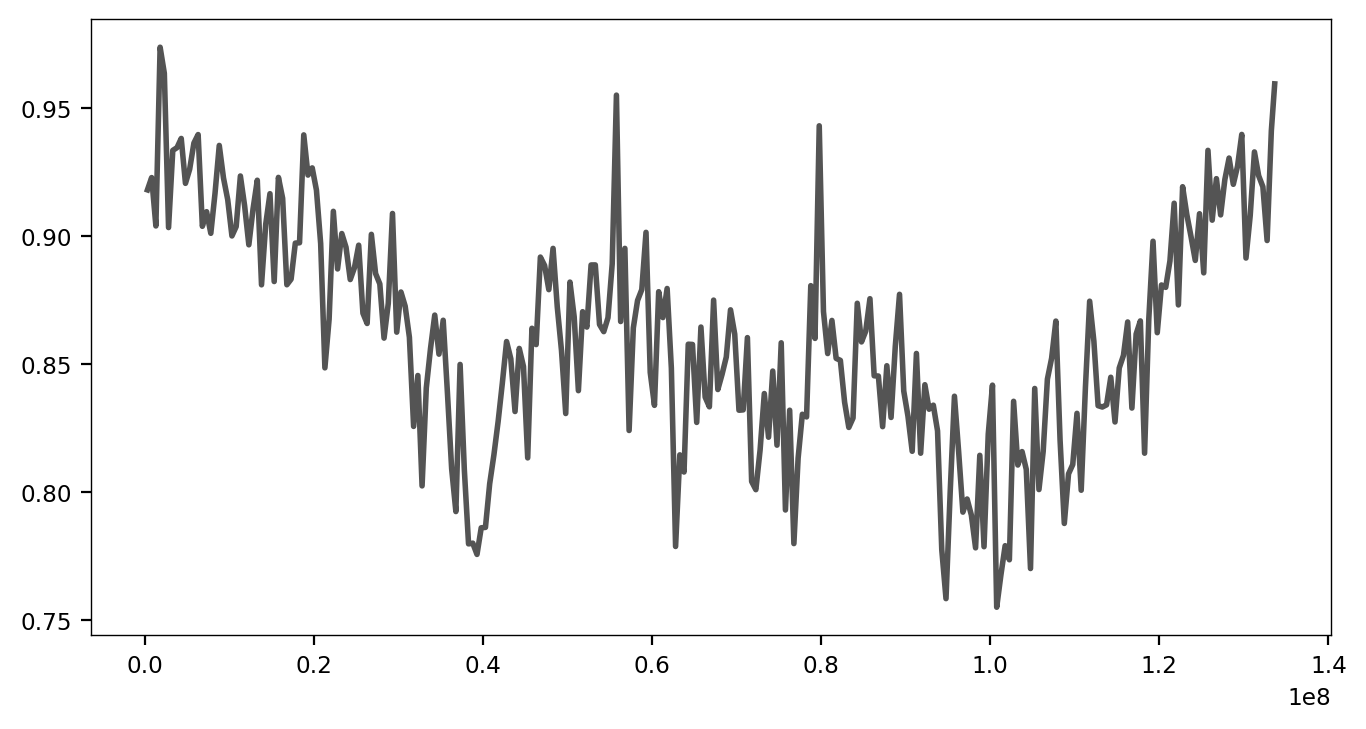

In [103]:
comparison_plot(1e-8, 0.1, b, bp, sims=sim_means_500kb, clcbg=mcvb, smoothfrac=0.0001)

Now, with even stronger selection:

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

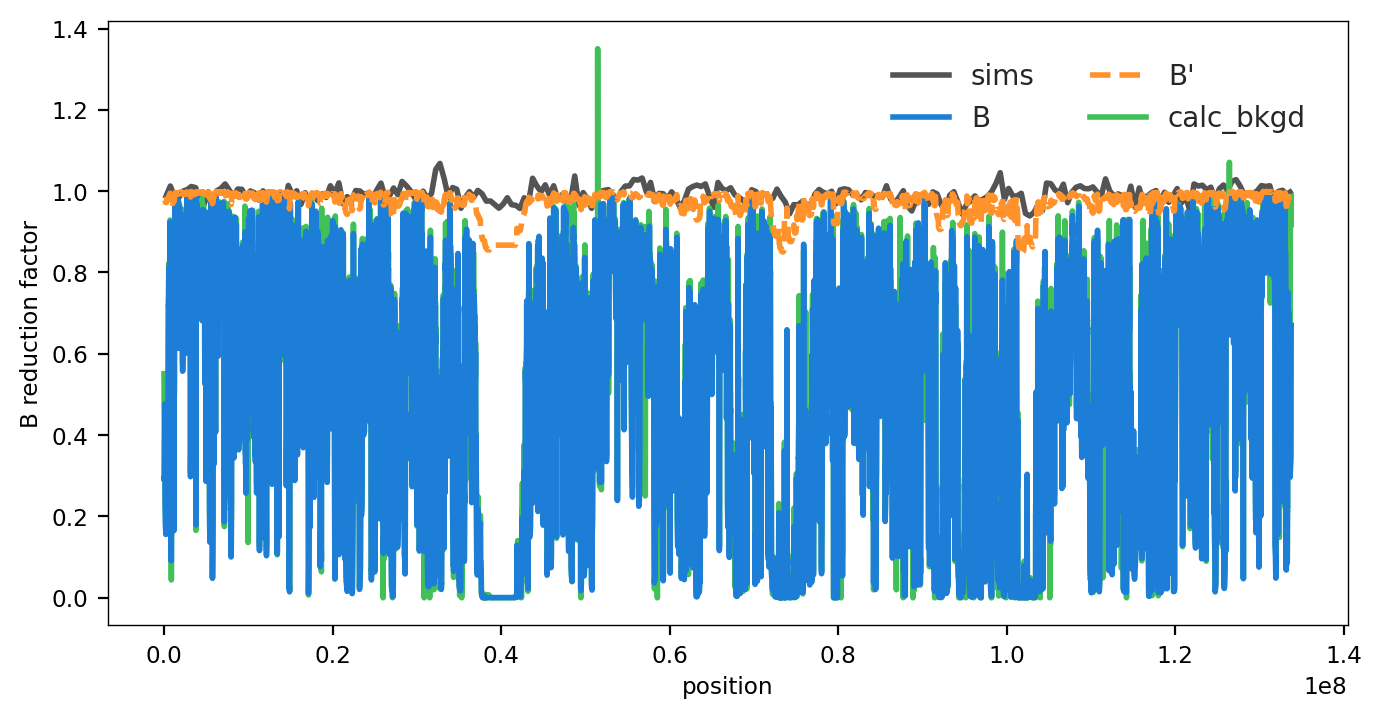

In [399]:
comparison_plot(m.w[5], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb, smoothfrac=None)

This shows why we need smoothing -- visually we cannot see anything.

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

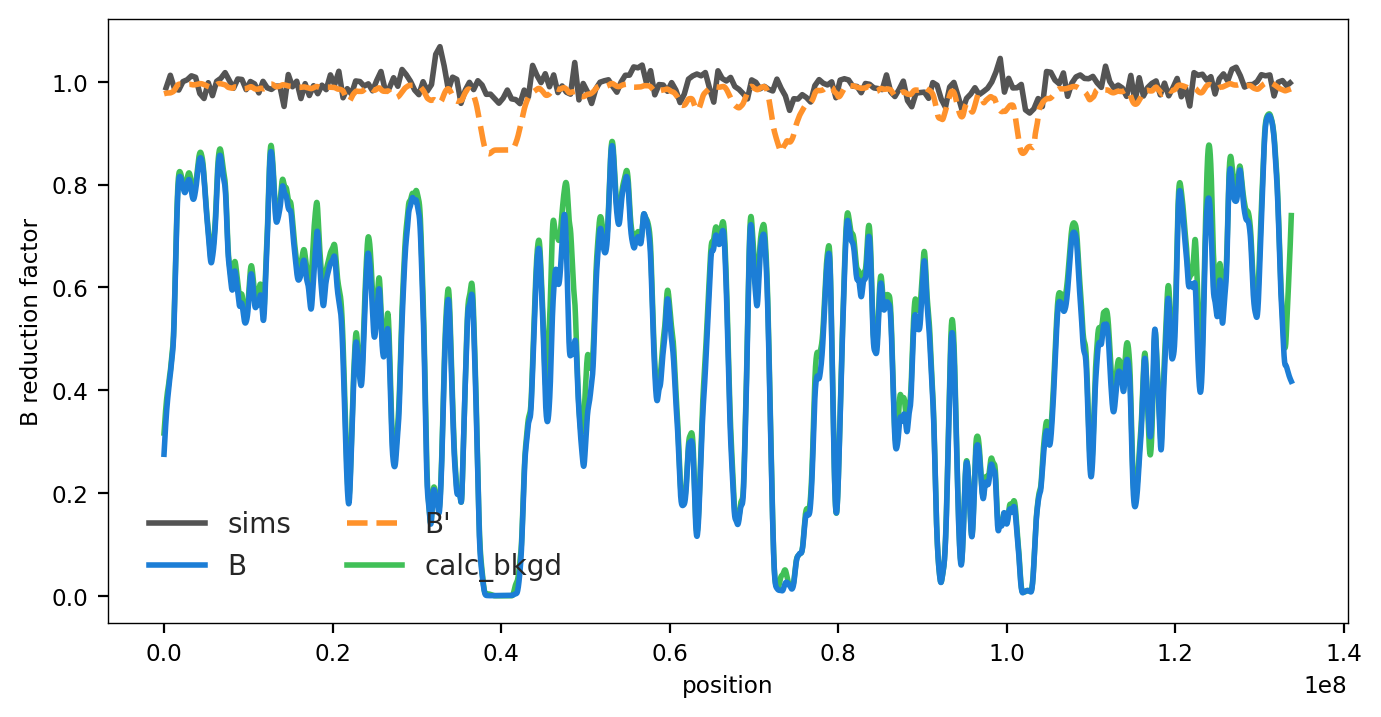

In [400]:
comparison_plot(m.w[5], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb, smoothfrac=1e-2)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

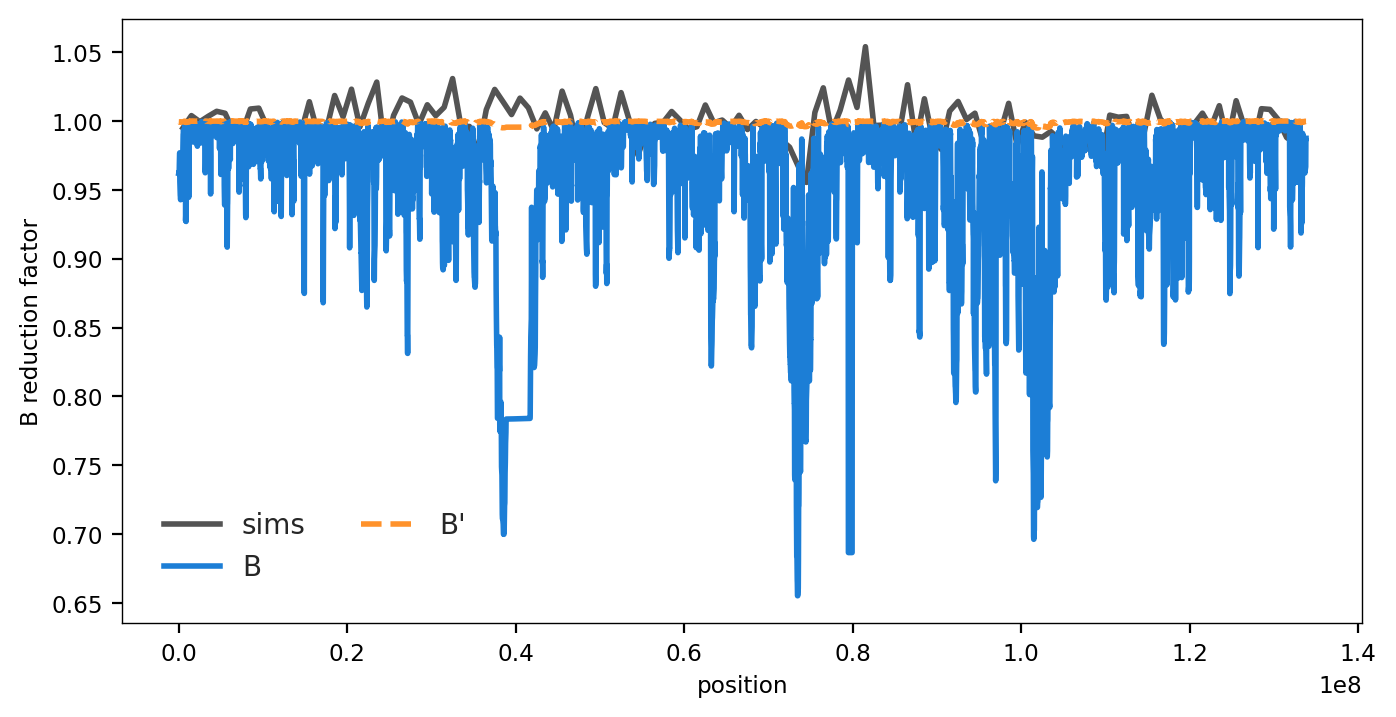

In [397]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_1Mb)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

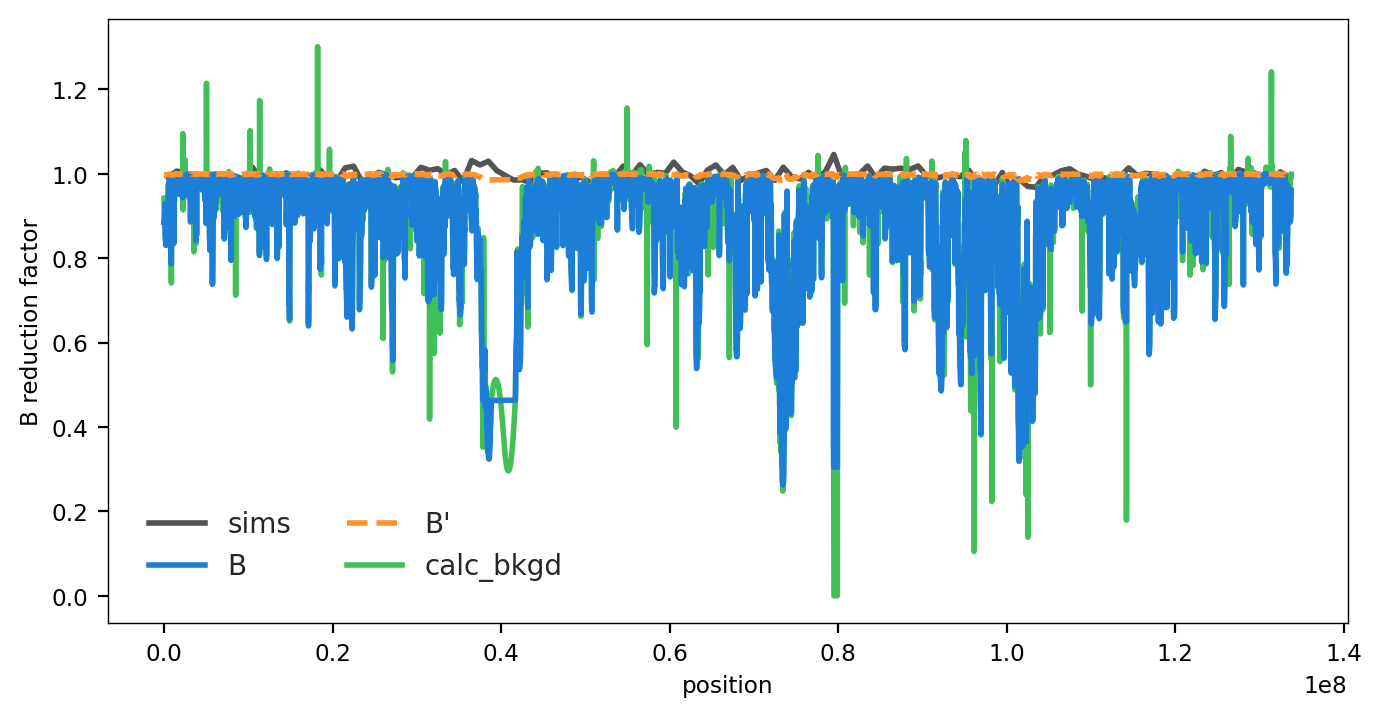

In [398]:
comparison_plot(m.w[3], m.t[4], b, bp, sims=sim_means_1Mb, clcbg=mcvb)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

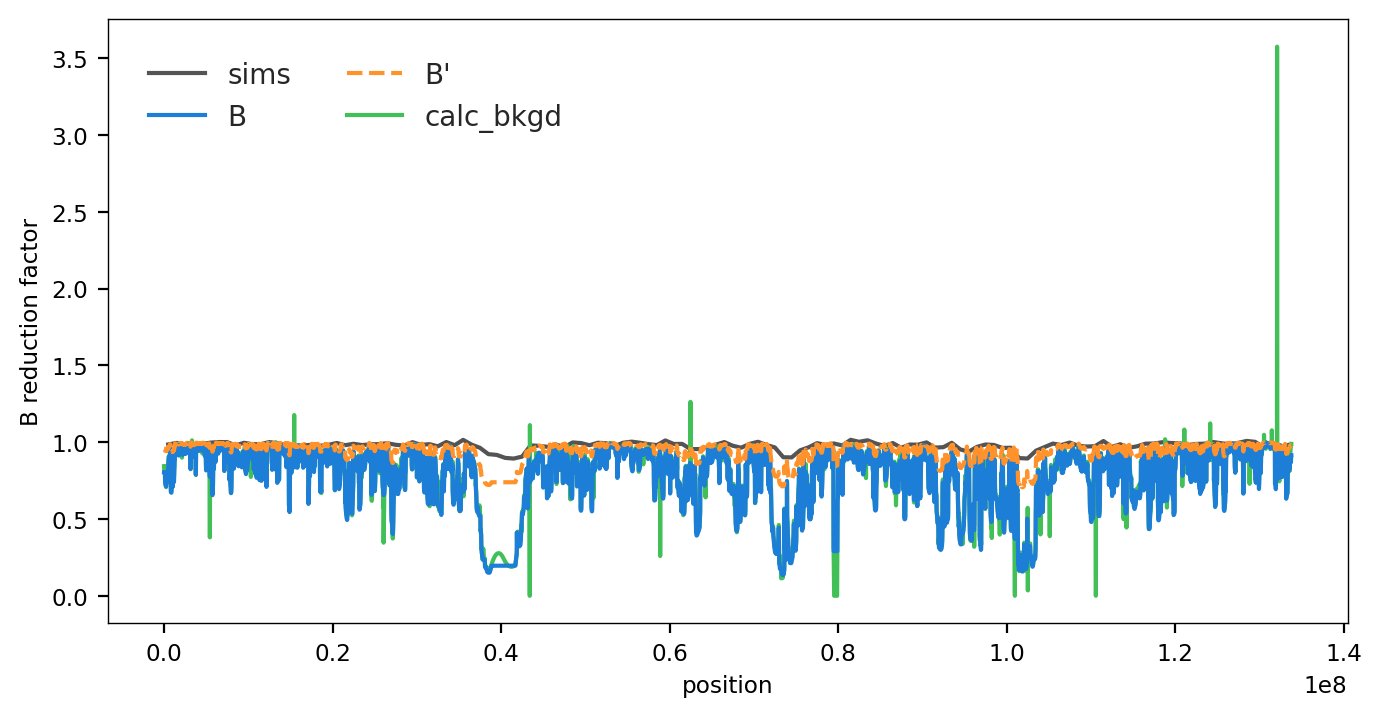

In [248]:
comparison_plot(m.w[4], m.t[5],  b, bp, sims=sim_means_1Mb, clcbg=mcvb)

(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot: xlabel='position', ylabel='B reduction factor'>)

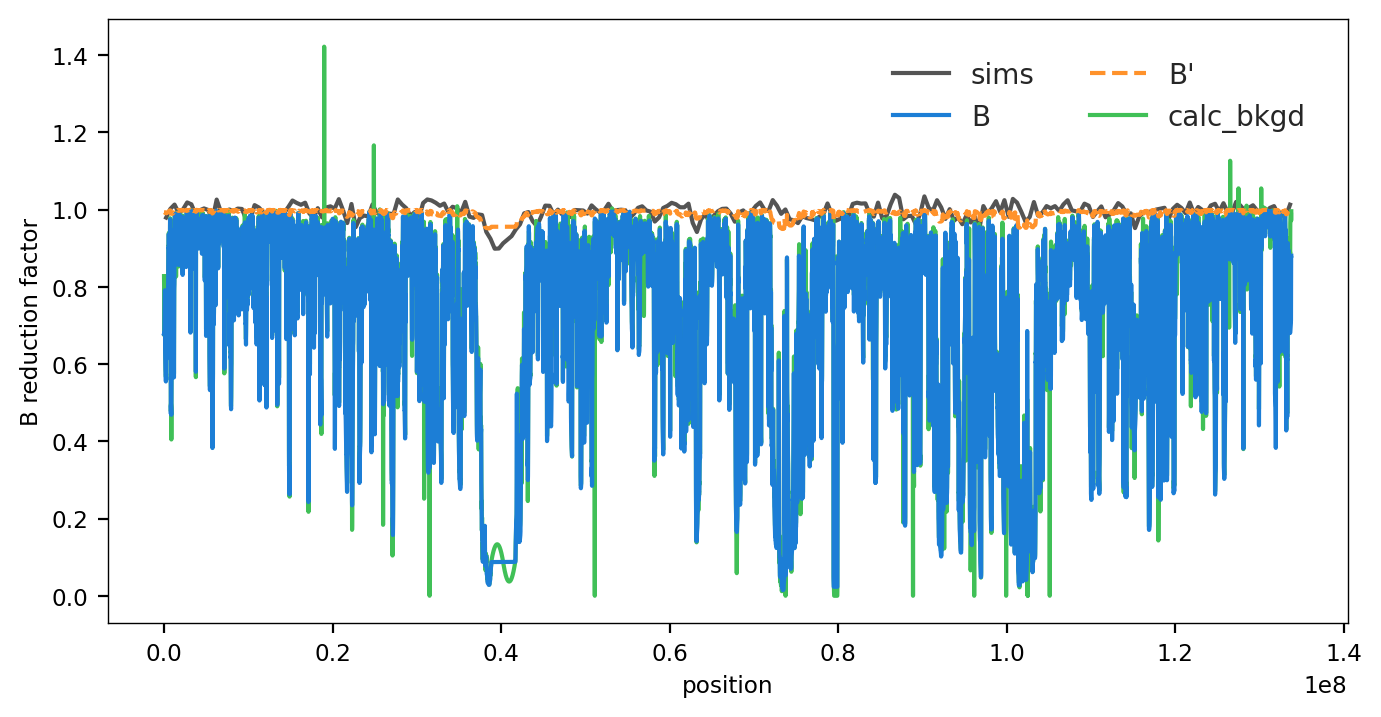

In [249]:
comparison_plot(m.w[4], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

(0.7, 1.1)

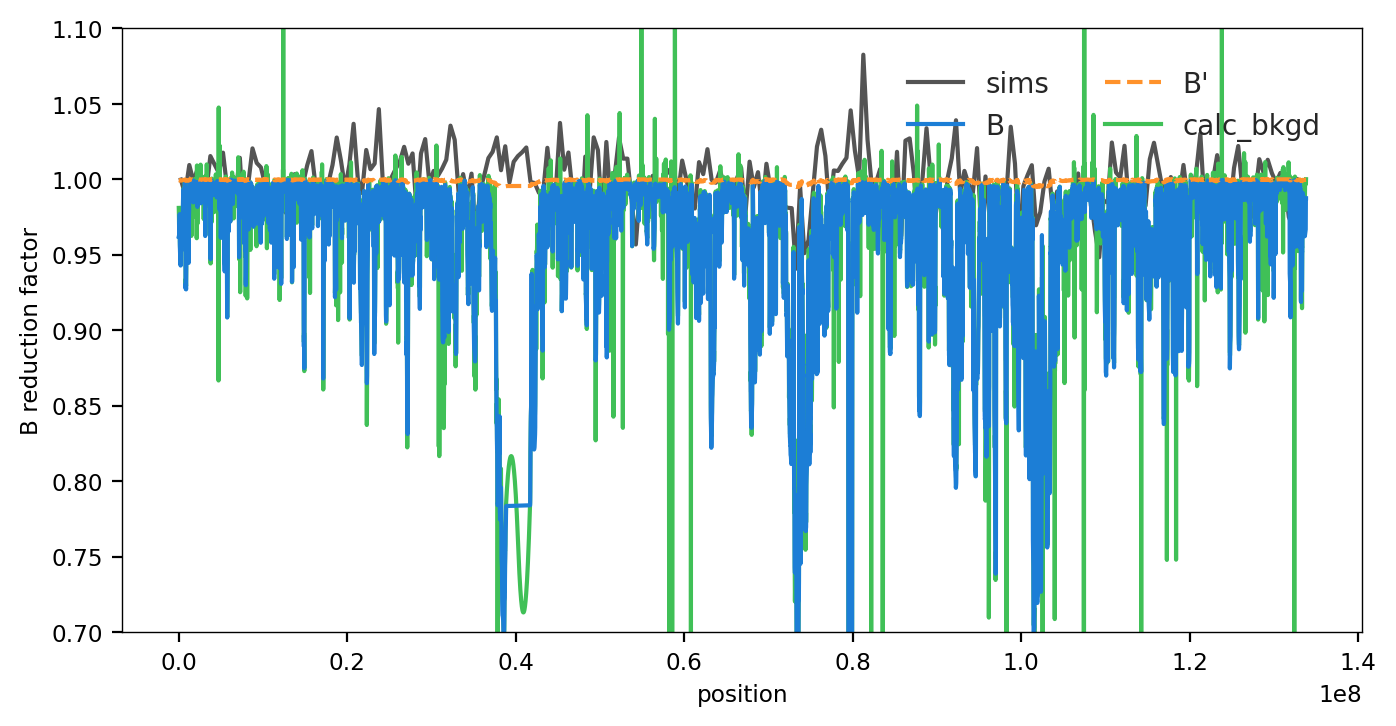

In [250]:
comparison_plot(1e-9, 0.0001, b, bp, sims=sim_means_500kb, clcbg=mcvb)
plt.ylim(0.7, 1.1)

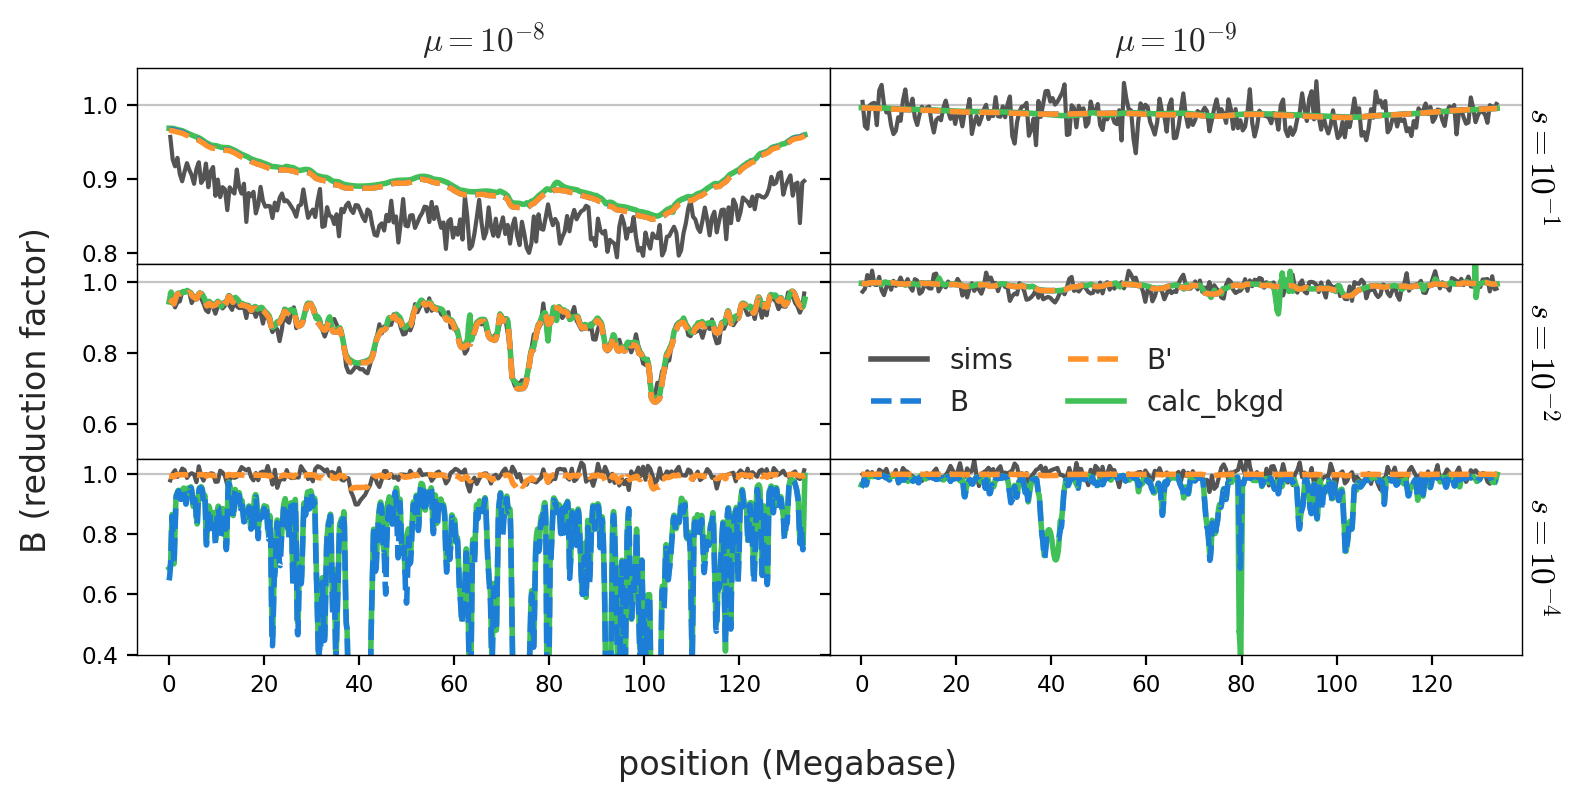

In [405]:
ts = [1e-1, 1e-2, 1e-4]
ws = [1e-8, 1e-9]


fig, ax = plt.subplots(ncols=len(ws), nrows=len(ts), sharey='row',
                      gridspec_kw = {'wspace':0, 'hspace':0})
for i, t in enumerate(ts):
    for j, w in enumerate(ws):
        fax = ax[i, j]
        lw = 2#, 0.9 if i < 1 else 0.7
        comparison_plot(w, t, b, bp, sims=sim_means_500kb, clcbg=mcvb,
                        legend=False, ylabel=None, xlabel=None,
                        dash_b=True, smoothfrac=5e-3,
                        figax=(fig, ax[i, j]), lw=lw, slw=1.5)
        if i == 1:
            fax.set_ylim(0.5, 1.05)
        if i == 2:
            fax.set_ylim(0.4, 1.05)            
        fax.set_ylim(ax[i, j].get_ylim()[0], 1.05)
        if i < 2:
            fax.xaxis.set_visible(False)
        fax.axhline(1, linewidth=0.8, c='0.77', zorder=-10)
        
        if i == 0:
            fax.set_title(f"$\\mu = 10^{ {int(np.log10(w))} }$")
            
        if j == 1:
            fax.yaxis.set_label_position("right")
            fax.set_ylabel(f"$s = 10^{ {int(np.log10(t))} }$", rotation=-90, labelpad=13, fontsize=12)
            
        if i == 1 and j == 1:
            fax.legend(ncols=2)
            
        if i == 2:
            fax.xaxis.set_major_formatter(chromosome_ticks_formatter(1e6))

        fax.set_xlim(fax.get_xlim()[0], 139e6) # prevent label overrun

fig.supxlabel("position (Megabase)")
fig.supylabel("B (reduction factor)")

leg = ax[1, 1].axes.get_legend()
for lh in leg.legendHandles:
    lh.set_linewidth(2)

plt.tight_layout()

fig.savefig("../manuscript/figures/supplementary/b_comparisons.pdf")

## At what scale do we see the BGS signal?


These B maps show something interesting: the ratio of noise to signal varies with the strength of selection and mutation. There is only a very narrow parameter range where the signal of genomic selective structure comes through.


We can describe the **background selection signal intensity** as the $\mathrm{E}(B)(x)$ and the variance over simulation replicates.

In [43]:
# We'll compare this to the real data, becase, why not
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

AttributeError: 'GenomeData' object has no attribute 'bin_pi'

In [21]:
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2
sim_1 = BScores({'chr10': np.log(sim_B['X'][..., 0])}, {'chr10': sims_pos}, mus, shs, step=None)

In [22]:
sim_1_1Mb = sim_1.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [23]:
bp.t

array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
       0.1     ])

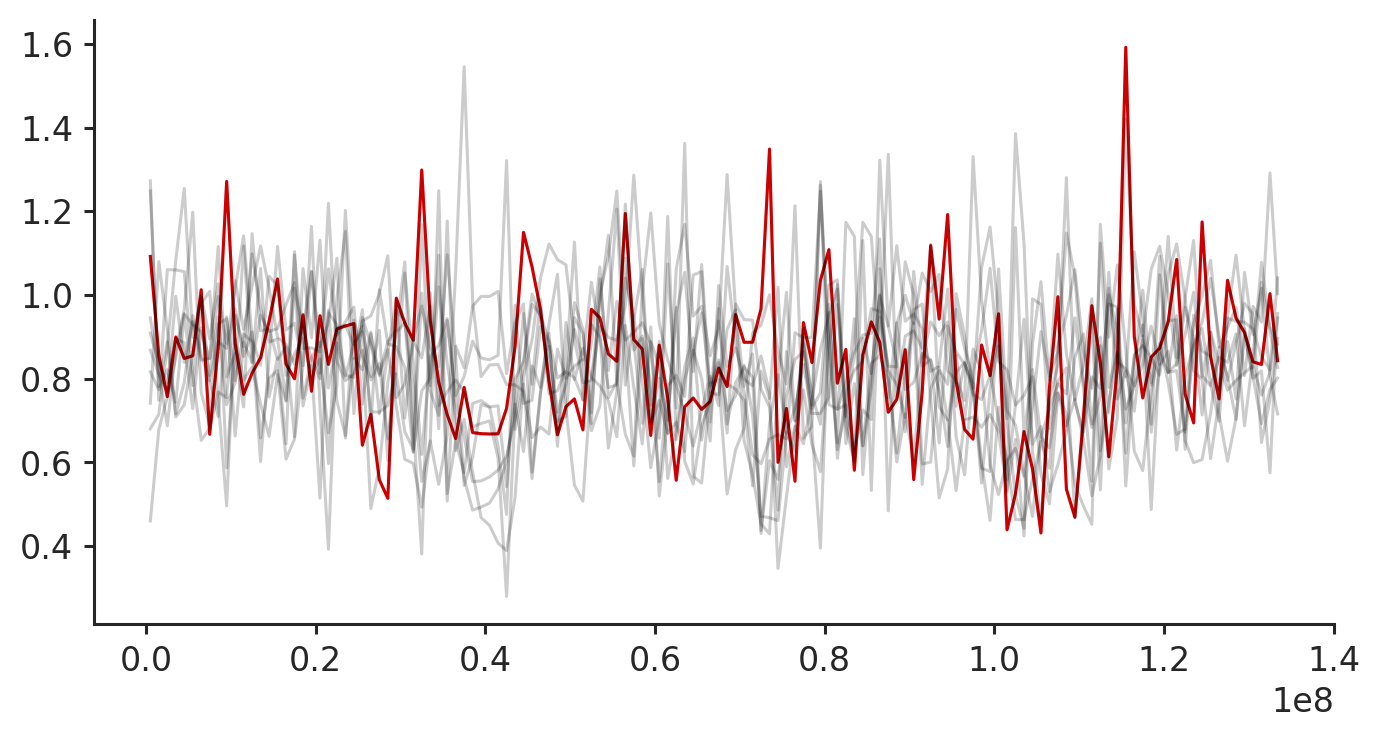

In [24]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-2)
_ = plt.plot(x, y, c='r', label='sim mean', zorder=2)

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-2)
for i in range(10):
    plt.plot(xx, yy[:, i], c='k', alpha=0.2)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


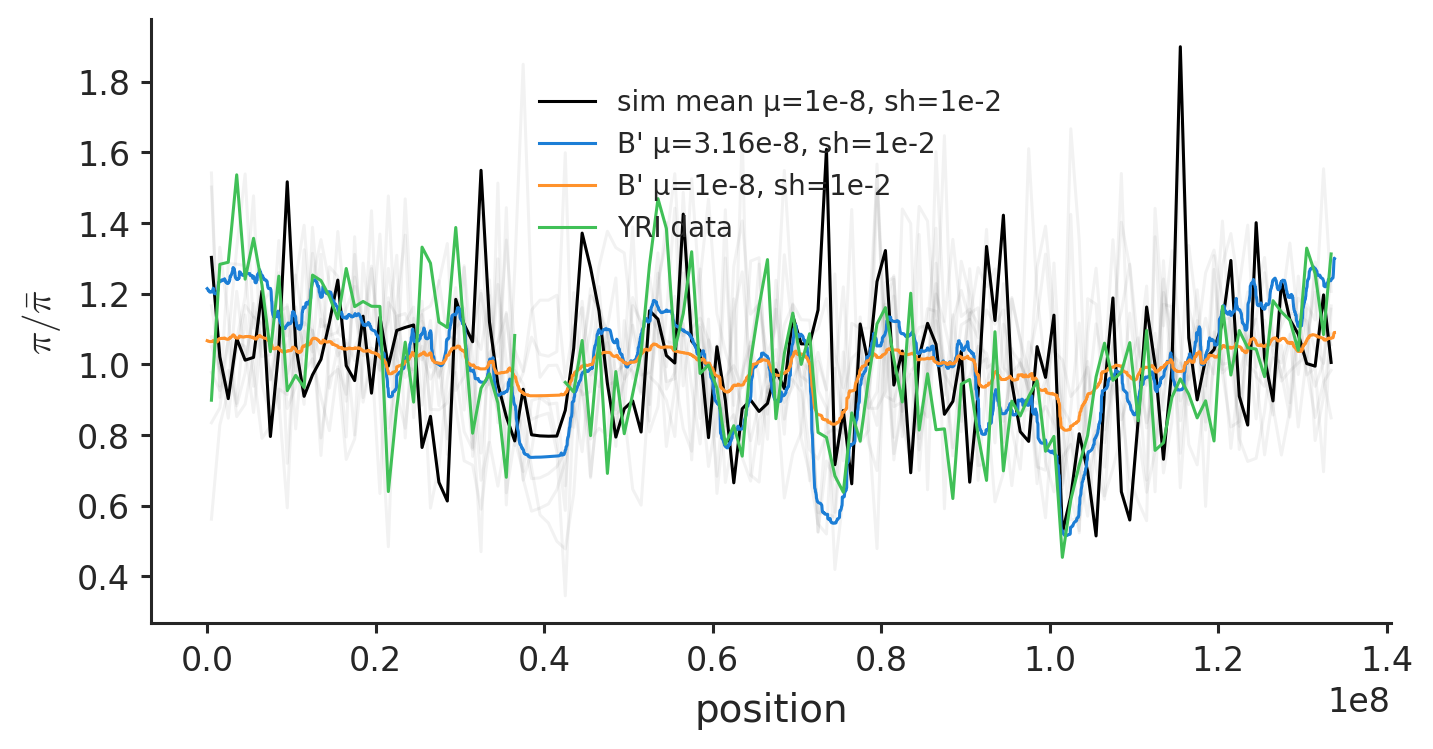

In [25]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-2)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean μ=1e-8, sh=1e-2')

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-2)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.05)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-2")
xx, yy = bp.pairs('chr10', 1e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-2")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

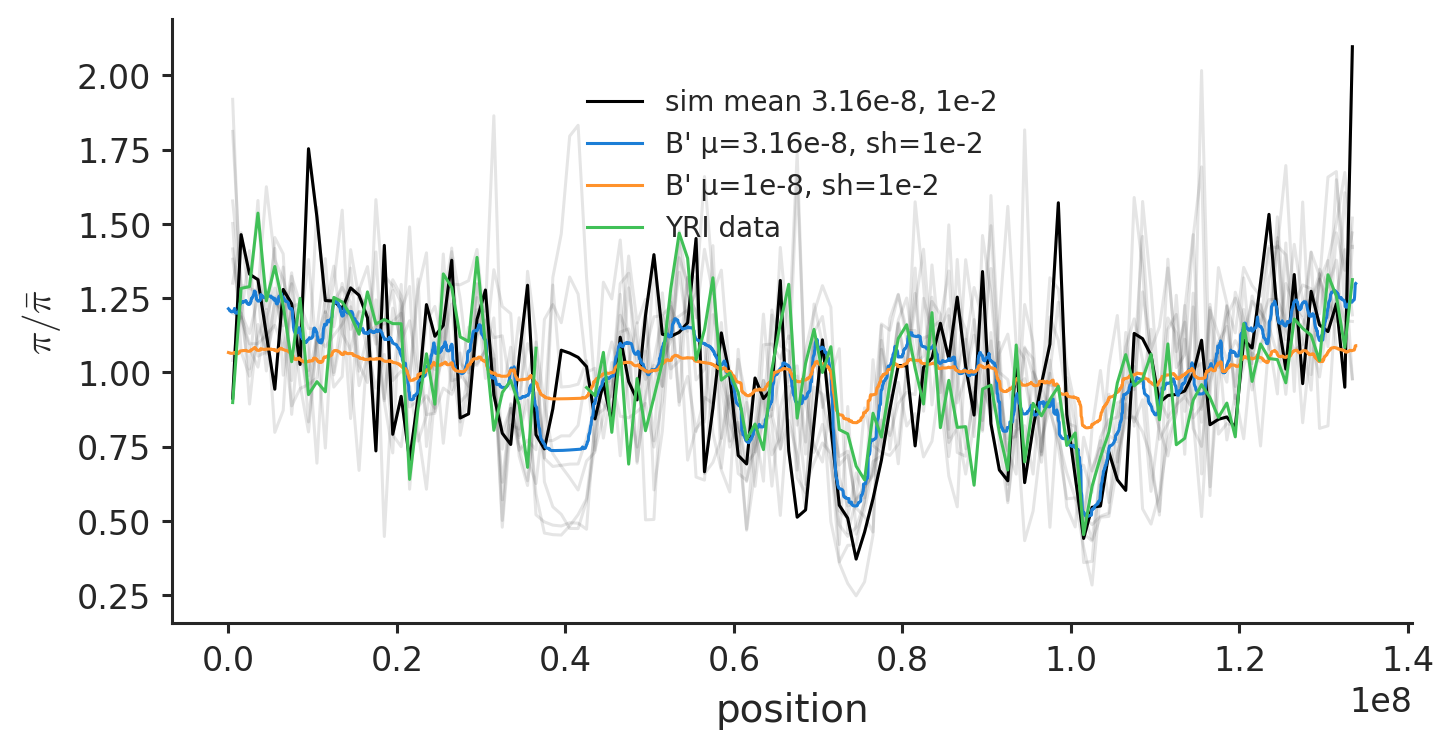

In [26]:
x, y = sim_1_1Mb.pairs('chr10', 3.16e-8, 1e-2)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean 3.16e-8, 1e-2')

xx, yy = sims_1Mb.pairs('chr10', 3.16e-8, 1e-2)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.1)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-2")
xx, yy = bp.pairs('chr10', 1e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-2")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

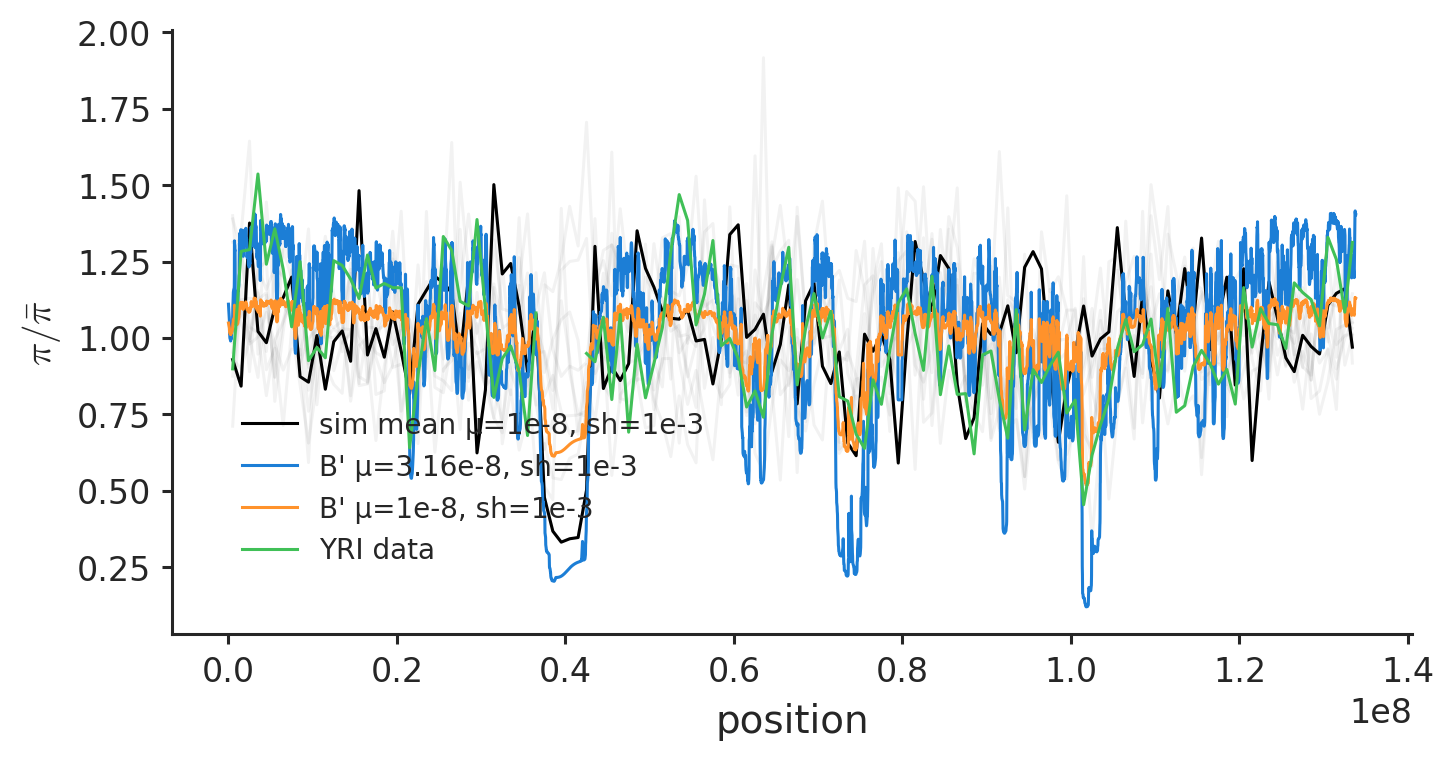

In [53]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-3)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean μ=1e-8, sh=1e-3')

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-3)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.05)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-3)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-3")
xx, yy = bp.pairs('chr10', 1e-8, 1e-3)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-3")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

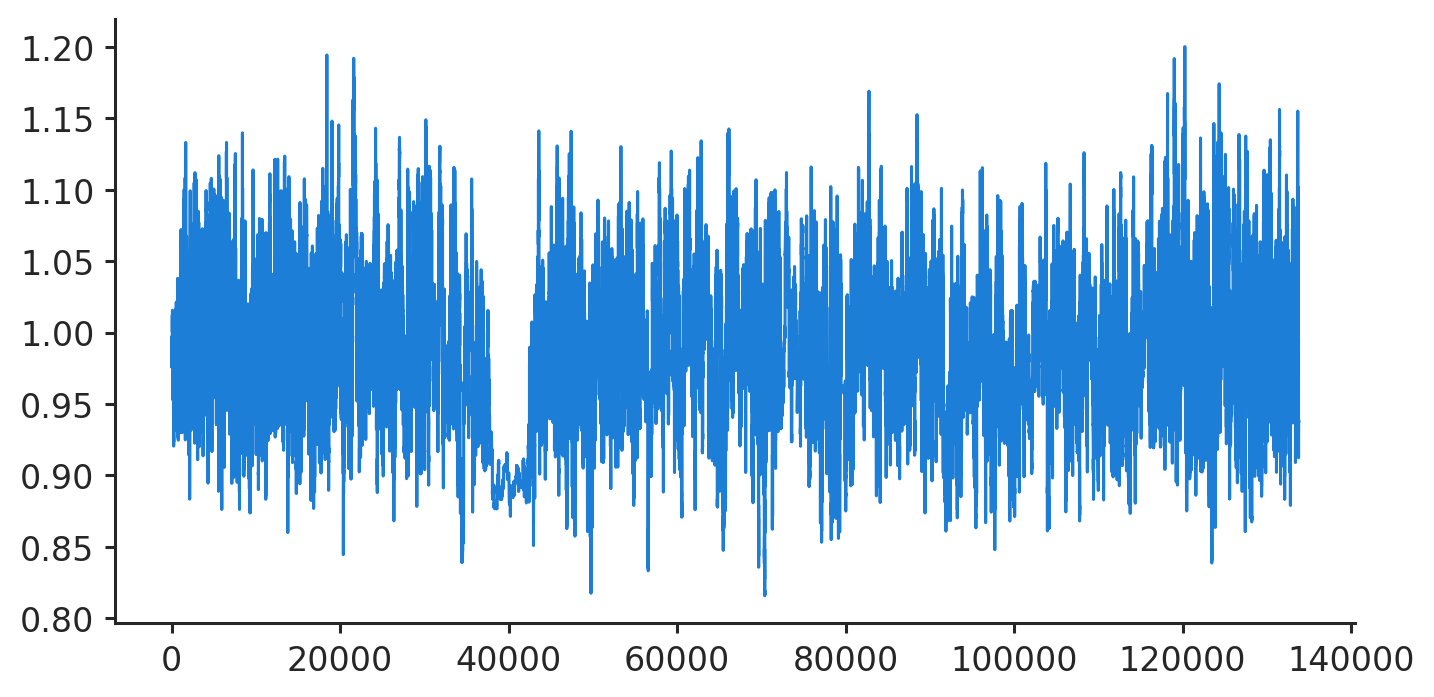

In [27]:
plt.plot(sim_B['X'].mean(axis=3)[:, 2, 5])

## Experiments with Dxy

In [ ]:
plt.scatter(sims_pos, sim_B['X'].mean(axis=3)[:, 2, 5], c='0.22', alpha=0.4, s=1)
plt.xlim(0.3e8, 0.4e8)

In [ ]:
plt.scatter(*sims_means.pairs('chr10', 1e-9, 1e-3), c='0.22', alpha=0.4, s=1)
plt.plot(*bp.pairs('chr10', 1e-9, 1e-4))
plt.plot(*b.pairs('chr10', 1e-9, 1e-4))
#plt.xlim(0.1e8, 0.4e8)


In [ ]:
import pandas as pd

In [ ]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo') & (dalt.spp2 == 'homo')]
dalt_dxy = dalt.loc[(dalt.stat == 'dxy') & (dalt.spp2 == 'homo') &  
                    ((dalt.spp1 == 'weastern_chimp') | (dalt.spp1 == 'eastern_chimp'))]

In [ ]:
bpy_1Mb = bp.bin_means(GenomicBins(g.seqlens, 1_000_000))
b_1Mb = b.bin_means(GenomicBins(g.seqlens, 1_000_000))

x, bpy = bpy_1Mb.pairs('chr10', 1e-9, 1e-4)
x, by = b_1Mb.pairs('chr10', 1e-9, 1e-4)
plt.plot(x, bpy/by)

In [ ]:
ddd = dalt_pi.loc[dalt_pi.chr == 'chr10']
fig, ax = plt.subplots()
ax.plot(ddd.midpoint, ddd.value)
ax2 = ax.twinx()
ax2.plot(x, bpy/by, c='r')

In [ ]:
plt.plot(np.sort(bpy/by))

In [ ]:
plt.scatter(bpy/by, ddd.value[2:])

## Analysis of Background Selection Signal Intensity

I calculate the signal intensity as $R^2$ between the simulation means $\bar{S}$ (across 100 replicates) and the $B'$ values.


In [44]:
from bgspy.likelihood import R2

def signal_intensity(w, t, b, sims):
    #nx, nw, nt, nf = b.shape
    bx, by = b.pairs('chr10', w, t)
    x, y = sims['chr10', w, t]
    assert bx.size == x.size, f"bin mismatch: {bx.size}, {x.size}"
    return R2(by, y)

signal_intensity(1e-8, 1e-4, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)


0.5166499396962909

In [45]:
R2s = []
ws, ts = [], []
for w, t in itertools.product(m.w, m.t):
    r2 = signal_intensity(w, t, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)
    R2s.append(r2)
    ws.append(w)
    ts.append(t)
    
df = pd.DataFrame(dict(w=ws, t=ts, R2=R2s))

In [46]:
df.head()

w         t        R2
0  1.000000e-10  0.000100  0.207030
1  1.000000e-10  0.000316 -0.416210
2  1.000000e-10  0.001000  0.038939
3  1.000000e-10  0.003160  0.052138
4  1.000000e-10  0.010000 -0.201848

Text(0.5, 0, 'mutation rate')

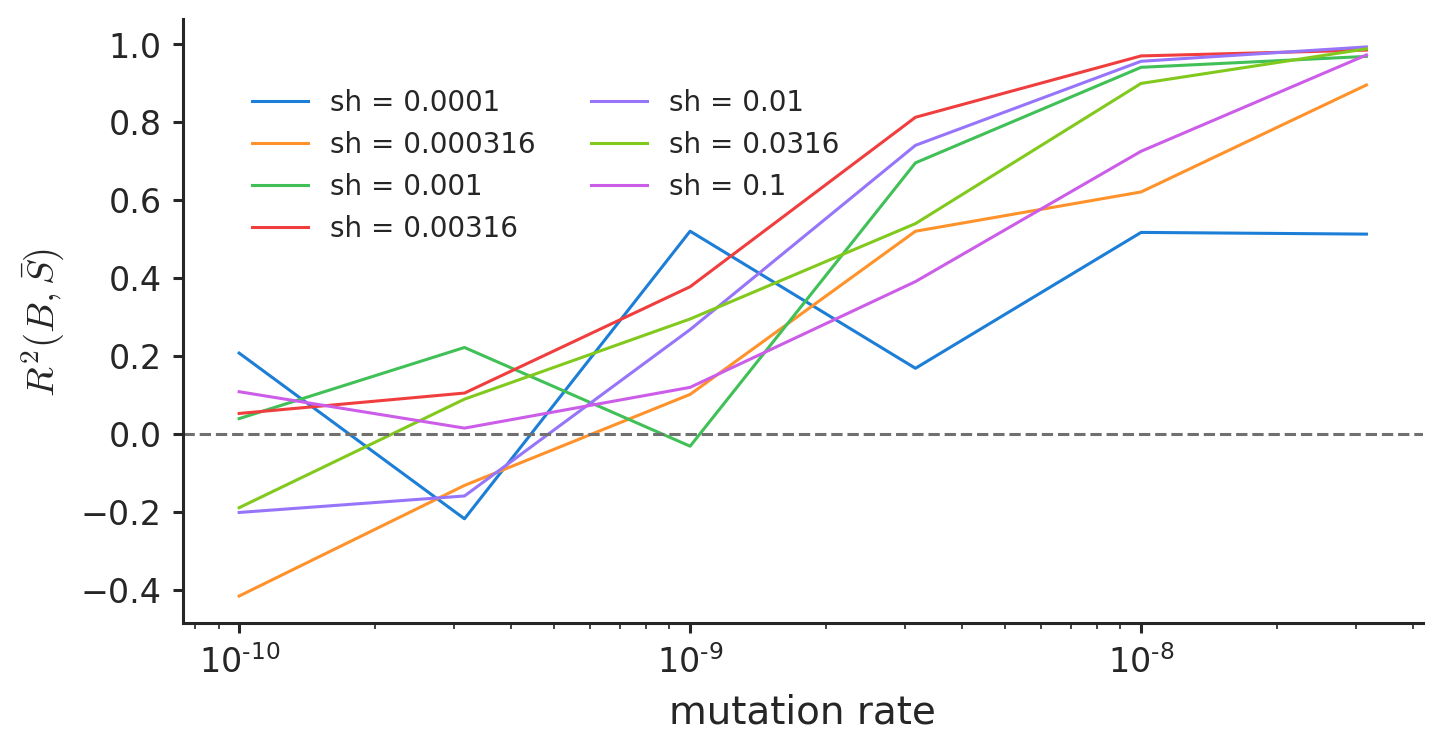

In [52]:
for t in m.t:
    ds = df.loc[df.t == t]
    plt.plot(ds.w, ds.R2, label=f"sh = {t}")
plt.semilogx()
plt.legend(loc='upper left', ncol=2)
plt.axhline(0, linestyle='dashed', c='0.44')
plt.ylabel('$R^2(B, \\bar{S})$')
plt.xlabel('mutation rate')

### Variance of the BGS process

What is the variance of the BGS process?

We estimate the variance across replicates in $B_\text{sim}$ as:

  $$
  \hat{\sigma}^2(B_\text{sim}) = \frac{1}{n-1} \sum_i (B_{\text{sim}, i} - \bar{B}_\text{sim})^2
  $$
  

$B_\text{sim}$ is estimated from the coalescent times of the simulation trees. Generally, it has a form like:

Note that if we use $\hat{B} = \pi / 4N$, $\text{Var}(\hat{B}) = \text{Var}(\pi)/4N^2$, which simplifies to (see Mathematica notebook):

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)}\frac{\mu}{4N}+\frac{2 \left(n^2+n+3\right)}{9 (n-1) n}\mu^2 $$

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)} \frac{\theta}{16N^2}  + \frac{2 \left(n^2+n+3\right)}{9 (n-1) n} \frac{\theta^2}{16N^2} $$
  

## Experiment: slop1k

In [72]:
slop1k = np.load('../data/chrombgs_chr10_merged_phastcons.npz')

In [73]:
slop1k_pos = (slop1k['pos'][1:] + slop1k['pos'][:-1])/2

In [74]:
slop1k['X'].shape

(133798, 6, 7, 50)

In [75]:
list(slop1k.keys())

['mu', 'sh', 'pos', 'X', 'nreps', 'mean', 'sd', 'files']

In [76]:
slop1k_sims = BScores({'chr10': np.log(slop1k['X'])}, {'chr10': sims_pos}, slop1k['mu'], slop1k['sh'], step=None)

In [77]:
slop1k_1Mb = slop1k_sims.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [78]:
slop1k_1Mb

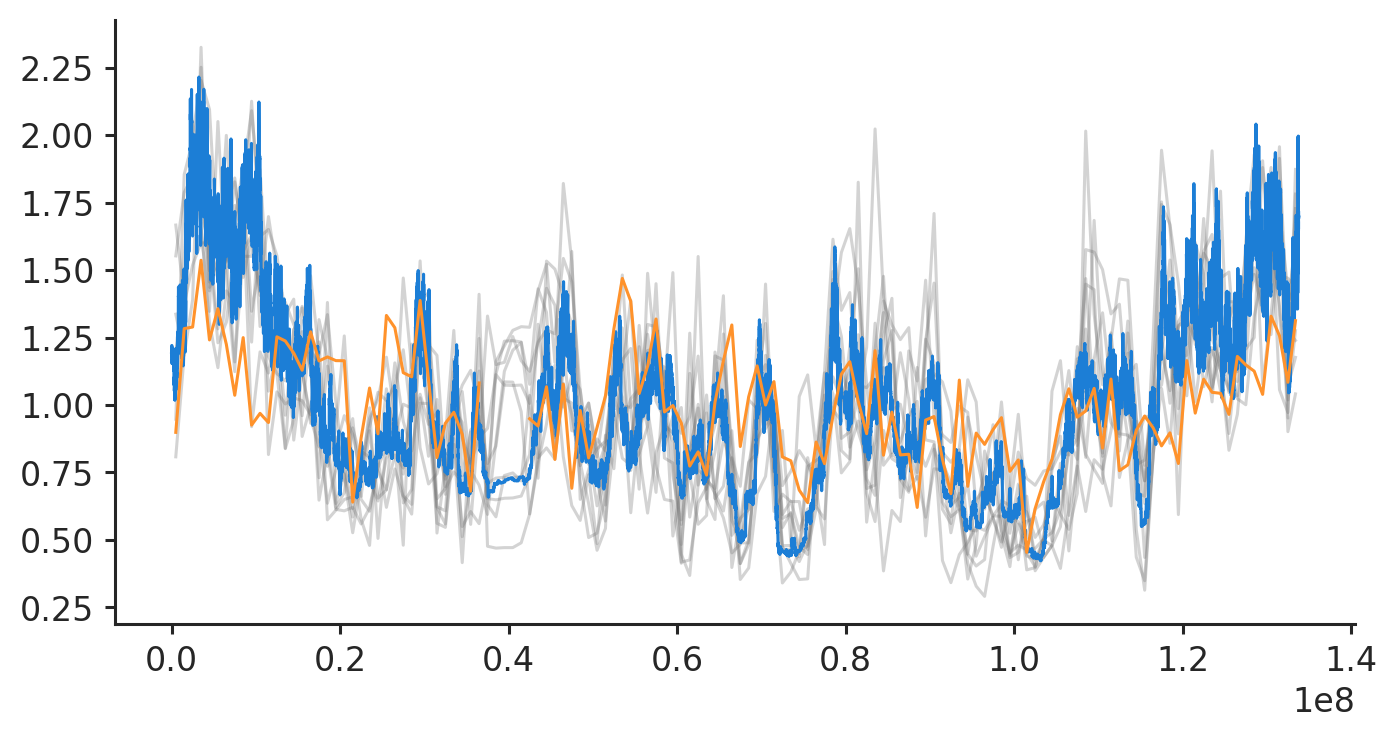

In [90]:
xx, yy = slop1k_1Mb['chr10', 1e-8, 1e-2]
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='0.44', alpha=0.3)

sims_means = BScores({'chr10': np.log(slop1k['mean'])}, {'chr10': slop1k_pos}, slop1k['mu'], slop1k['sh'], step=None)
xx, yy = sims_means['chr10', 1e-8, 1e-2]
plt.plot(xx, mean_ratio(yy))
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")

## Simulations

In [ ]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sims_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

In [ ]:
def B_bins(x, y, nbins):
    bm = stats.binned_statistic(x, y, np.nanmean, bins=nbins)
    mps = (bm.bin_edges[1:] + bm.bin_edges[:-1])/2
    return mps, bm.statistic

In [ ]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 10000
nbins = 50
idx = np.random.randint(0, len(sims_pos), n)
pos = sims_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(5, 6))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(*B_bins(y, x, nbins), s=3)
    ax[j, i].scatter(*B_bins(ya, x, nbins), s=3)
    
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")

f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [ ]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()